# Homework 2 - Data from the web (II)
## Assignment 2 (Bonus assignment at the bottom)
Perform a similar operation to what described above, this time for Master students. Notice that this data is more tricky, as there are many missing records in the IS-Academia database. Therefore, try to guess how much time a master student spent at EPFL by at least checking the distance in months between `Master semestre 1` and `Master semestre 2`. If the Mineur field is not empty, the student should also appear registered in `Master semestre 3`. Last but not the least, don't forget to check if the student has an entry also in the `Projet Master` tables. Once you can handle well this data, compute the "average stay at EPFL" for master students. Now extract all the students with a `Spécialisation` and compute the "average stay" per each category of that attribute -- compared to the general average, can you find any specialization for which the difference in average is statistically significant?

### Getting the parameters
Useful usual imports at first

In [1]:
from bs4 import BeautifulSoup
import urllib.request
import pandas as pd
import html5lib 
from lxml import html
import numpy as np
from helpers import *
#import helpers as helpers

Extracting the master students in the similar fashion we did in the first assignment : we associate each year/master stage with its value, that we extract from the html page using the BeautifulSoup package.

In [2]:
# The URL of the "start" of the IS-Academia page listing the students.
home_url = "http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?ww_x_GPS=-1&ww_i_reportModel=133685247"

# The general form of the URL, with the fields to be replaced later (e.g. [UNITE_ACADEMIQUE])
base_url = "http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html?ww_x_GPS=-1&ww_i_reportModel=133685247&ww_i_reportModelXsl=133685270&ww_x_UNITE_ACAD=[UNITE_ACADEMIQUE]&ww_x_PERIODE_ACAD=[PERIODE_ACADEMIQUE]&ww_x_PERIODE_PEDAGO=[PERIODE_PEDAGOGIQUE]&ww_x_HIVERETE=null"

# Get the raw content from the page
with urllib.request.urlopen(home_url) as url:
    s = url.read()

soup = BeautifulSoup(s, 'html.parser')

# Parse the content
url_section = 0
url_years = {}
url_master = {}

#For loop on all the possible fields with <option> to get the value associated with each year, or each "Bachelor" semester
for link in soup.find_all('option'):
    if link.text == 'Informatique':
        url_section = link.get('value')
    if "20" in link.text:
        url_years[link.text] = link.get('value')
    if 'Master' in link.text or 'Mineur' in link.text:
        url_master[link.text] = link.get('value')

        
print(url_years)
print(url_master)

{'2008-2009': '978187', '2015-2016': '213638028', '2009-2010': '978195', '2012-2013': '123456101', '2011-2012': '123455150', '2010-2011': '39486325', '2013-2014': '213637754', '2007-2008': '978181', '2016-2017': '355925344', '2014-2015': '213637922'}
{'Master semestre 3': '2230128', 'Projet Master printemps': '3781783', 'Master semestre 2': '942192', 'Master semestre 4': '2230140', 'Master semestre 1': '2230106', 'Projet Master automne': '249127', 'Mineur semestre 1': '2335667', 'Mineur semestre 2': '2335676'}


Function that replaces the general fields in the base_url with the fields for a given year and level of study

In [3]:
def getFullUrl(PeriodeAcad, PeriodePedag):
    """
    Given an academic period (years) and a pedagogic period (bachelor semester), 
    fills the general URL with the values associated to those parameters.
    
    @param PeriodeAcad :  Academic year string, in the form ('2015-2016')
    @param PeriodePedag : Pedagogic period string, in the form ('Bachelor x')
    @return url :         The complete url associated to those period, from which we can fetch the students.
    
    """
    url = base_url
    url = url.replace('[UNITE_ACADEMIQUE]', str(url_section))
    url = url.replace('[PERIODE_ACADEMIQUE]', str(url_years[PeriodeAcad]))
    url = url.replace('[PERIODE_PEDAGOGIQUE]', str(url_master[PeriodePedag]))
    return url

### Extracting and formatting the data
We noticed that in the way the EPFL master works, we will have all students that start in the autumn semester in `MS1` and then moves onto the `MS2`, then every subsequent autumn semester that he does will be counted into `MS3`.

The way our data structure extracts the information we want from the table of students is as simple as possible. Keeping track of a student and noting each semester in which is present can be quite tricky, even very difficult, due to the holes into the IS-Academia data. The simplest way we found to address this problem is not trying to make any assumptions into where a student that disappears goes during the whole in the data. We count each time a student appears in ones of the master semesters or master project semesters and add a $1$ each time we find an occurence of the same student. Hence its master duration will be the sum of the semesters in which the student appears.

In [4]:
def MasterStart(year,master_student,pedag) : 
    """
    Given a year and a pedagogic period, edits the master_student frame, adding the students 
    that are not present and editting the values for the ones present (adding a +1 for the pedagogic period)
    
    @param year_string :    Academic year string, in the form ('2015-2016')
    @param master_student : DataFrame containing the occurrence of each students into any possible semester of the master.
    @param pedag :          Pedagogic period string (e.g. in the form 'Master semestre x')
    @return master_student: The editted version of our DataFrame.
    
    """  
    year_string = str(year) + '-' + str(year+1)
    #Reading the HTML page
    current_url = getFullUrl(year_string, pedag)
    
    with urllib.request.urlopen(current_url) as url:
        html = url.read()
    soup = BeautifulSoup(html, 'html.parser')
    master_frame = pd.read_html(soup.prettify(), header=1)
    
    #If the page has actually some students in it.
    if  len(master_frame)>0 :
        master_frame = master_frame[0].drop(0,axis=0)
        master_frame_sciper = master_frame[['No Sciper']]
        master_frame = master_frame.set_index('No Sciper')
        for sciper in master_frame_sciper.values:
            sciper = sciper[0]
            
            #As a student can be in 'Master semestre 1' only once, we add all of them automatically.
            if pedag == 'Master semestre 1' or sciper not in master_student.index:
                master_student.loc[sciper] = 0   
                master_student.loc[sciper,pedag] = 1
                master_student.loc[sciper,'Starting Year'] = year
            else :
                master_student.loc[sciper,pedag] += 1   
            master_student.loc[sciper,'Civilité'] = master_frame.loc[sciper,'Civilité']
            master_student.loc[sciper,'Nom Prénom'] = master_frame.loc[sciper,'Nom Prénom']
            master_student.loc[sciper,'Spécialisation'] = master_frame.loc[sciper,'Spécialisation']
            master_student.loc[sciper,'Mineur'] = master_frame.loc[sciper,'Mineur']
    return master_student

We perform here the extraction from all the years and master stages for each student we find, going from the period 2007 to 2016, counting for each student. The following essentially calls the `MasterStart` function at each iteration.

Further down, we will perform some filtering in order to remove from the DataFrame students that cause an obvious bias. We will remove them according to those 3 criteria :
 1. If there are no entries in `Master semestre 1` for a student in the year 2007-2008, we erase it from our DataFrame, as it is most likely that the student has started in the previous year.
 2. If there is an entry in `Master semestre 1` for a student in the year 2015-2016, we erase it from our DataFrame, as he will not have enough time to complete his master in the data we have.
 3. Then, after having done that, we will remove from our DataFrame all the students that have only 1 semester of presence over their whole cursus, because we do not have enough data about them to make reasonable assumptions.

In [5]:
# In the following we retrieve all the students from IS-Academia
master_student = pd.DataFrame(columns = ['Civilité', 'Nom Prénom', 
                                         'Master semestre 1', 'Master semestre 2', 'Master semestre 3',
                                         'Projet Master printemps', 'Projet Master automne', 
                                         'Spécialisation', 'Mineur','Starting Year'])
master_student.index.name = 'No Sciper'

pedagogic_year = ['Master semestre 1','Master semestre 2','Master semestre 3',
                  'Projet Master printemps','Projet Master automne']
for year in range(2007,2016):   
    for pedag in  pedagogic_year :
         master_student = MasterStart(year,master_student,pedag)

In [6]:
# Here, we filter the students accordingly to the criteria given above

# 1. Remove students with no MS1 in 2007-2008
master_student = master_student[np.logical_not((master_student['Starting Year'] ==2007)&(master_student['Master semestre 1']==0))]
# 2. Remove students in MS1 in 2015-2016
master_student = master_student[np.logical_not((master_student['Starting Year'] ==2015)&(master_student['Master semestre 1']==1))]
# 3. Remove students with only one semester of presence overall
course_time = (master_student['Master semestre 1']+master_student['Master semestre 2']+
        master_student['Master semestre 3']+master_student['Projet Master printemps']+
        master_student['Projet Master automne'])
master_student = master_student[course_time>1]

master_student.sort_values(ascending =[True, True],by=['Master semestre 1','Master semestre 2']).head()

,Civilité,Nom Prénom,Master semestre 1,Master semestre 2,Master semestre 3,Projet Master printemps,Projet Master automne,Spécialisation,Mineur,Starting Year
No Sciper,,,,,,,,,,
170525,Monsieur,Galimberti Davide,0.0,1.0,1.0,0.0,0.0,NaN,NaN,2008.0
175190,Monsieur,Hanser Valérian,0.0,1.0,1.0,1.0,0.0,NaN,NaN,2010.0
202878,Madame,Tapandjieva Gorica,0.0,1.0,1.0,0.0,0.0,NaN,NaN,2010.0
184772,Monsieur,Arnfred Jonas,0.0,1.0,1.0,0.0,0.0,NaN,Area and Cultural Studies minor,2011.0
232468,Madame,Bagcioglu Egeyar Özlen,0.0,1.0,2.0,0.0,0.0,Internet computing,NaN,2014.0


### Analysing the data and performing the statistical tests
**Assumptions**  : 
 - It is possible to have project master in spring and autumn (not really an assumption, but we realise it's possible to fail the master project and redo it, so the data is valid).
 - If no `projet master` field has been found, we assume that the student had his project outside epfl and add $+1$ semester to the total duration of his master. Because if we were to remove all the students with no master project entry in our data, we would get rid of most of the students we have, as there seems to be extensive holes in IS-Academia's data about master projects.

In [7]:
print(master_student.index.is_unique)
# We take the total duration and add 1 semester if there are no fields in PDM spring or autumn
time = (course_time + 1-((master_student['Projet Master printemps']+ master_student['Projet Master automne'])>=1)) 
master_student['Time to Finish']= time
master_student.sort_values(ascending=[True,True],by=['Master semestre 1', 'Master semestre 2']).head()

True


,Civilité,Nom Prénom,Master semestre 1,Master semestre 2,Master semestre 3,Projet Master printemps,Projet Master automne,Spécialisation,Mineur,Starting Year,Time to Finish
No Sciper,,,,,,,,,,,
170525,Monsieur,Galimberti Davide,0.0,1.0,1.0,0.0,0.0,NaN,NaN,2008.0,3
175190,Monsieur,Hanser Valérian,0.0,1.0,1.0,1.0,0.0,NaN,NaN,2010.0,3
202878,Madame,Tapandjieva Gorica,0.0,1.0,1.0,0.0,0.0,NaN,NaN,2010.0,3
184772,Monsieur,Arnfred Jonas,0.0,1.0,1.0,0.0,0.0,NaN,Area and Cultural Studies minor,2011.0,3
232468,Madame,Bagcioglu Egeyar Özlen,0.0,1.0,2.0,0.0,0.0,Internet computing,NaN,2014.0,4


We now perform the statistical test to determine whether doing a specialisation effectively has an effect on the duration of the master. We chose a **1-sample T-test**, as we want to compare if the difference from the mean duration of the master without any specialisation is statistically significant. Our null hypothesis is then that the two samples are from the ame distribution.

In [8]:
import scipy.stats as stats
specialisation = master_student[master_student['Spécialisation']==master_student['Spécialisation']]                        
mean_time_specialisation = specialisation['Time to Finish']
mean_time  = master_student['Time to Finish'].mean()
print('Mean time for a master: ',mean_time,'vs Mean time for a master with a specialisation: ',mean_time_specialisation.mean())
stats.ttest_1samp(a= mean_time_specialisation, 
                 popmean= mean_time)

Mean time for a master:  4.17839607201 vs Mean time for a master with a specialisation:  4.67914438503


Ttest_1sampResult(statistic=7.9861088560362354, pvalue=1.408381869015009e-13)

The result shows VERY clearly that the difference is meaningful, as the p-value is almost zero, rejecting our null hypothesis. We can see even by eye from the averages that we have at least a 0.5 longer master duration for the people doing a specialisation.

**Now extract all the students with a `Spécialisation` and compute the "average stay" per each category of that attribute -- compared to the general average, can you find any specialization for which the difference in average is statistically significant?**

The way we will proceed is the following : 
- we will remove all students without a specialisation
- we will group all the students with a specialisation
- we will try to see whether the difference in the mean duration of the master is significant compared to the mean duratin of the master

In [9]:
#Remove all the students that don't have a specialisation.
master_student_with_Spec = master_student[master_student.Spécialisation == master_student.Spécialisation]

#Lists of the specialisations for the master 
list_Spec = master_student_with_Spec['Spécialisation'].drop_duplicates().values

#We group all the students by specialisation
master_student_with_Spec.reset_index(level=0, inplace=True)
master_student_with_Spec = master_student_with_Spec.set_index(['Spécialisation', 'No Sciper'])
master_student_with_Spec = master_student_with_Spec.sort_index()
master_student_with_Spec.head()

Civilité              Nom Prénom  \
Spécialisation            No Sciper                                     
Biocomputing              154573       Madame      Benabdallah Zeineb   
                          169734     Monsieur          Koller Yannick   
                          183185       Madame          Yurovsky Alisa   
Computer Engineering - SP 166262     Monsieur       Plancherel Pascal   
                          178271     Monsieur  Boéchat Marc-Alexandre   

                                     Master semestre 1  Master semestre 2  \
Spécialisation            No Sciper                                         
Biocomputing              154573                   1.0                2.0   
                          169734                   1.0                2.0   
                          183185                   1.0                1.0   
Computer Engineering - SP 166262                   1.0                1.0   
                          178271                   1.0                1.0   

                                     Master semestre 3  \
Spécialisation            No Sciper                      
Biocomputing              154573                   2.0   
                          169734                   2.0   
                          183185                   1.0   
Computer Engineering - SP 166262                   1.0   
                          178271                   1.0   

                                     Projet Master printemps  \
Spécialisation            No Sciper                            
Biocomputing              154573                         1.0   
                          169734                         0.0   
                          183185                         0.0   
Computer Engineering - SP 166262                         0.0   
                          178271                         0.0   

                                     Projet Master automne Mineur  \
Spécialisation            No Sciper                                 
Biocomputing              154573                       0.0    NaN   
                          169734                       0.0    NaN   
                          183185                       0.0    NaN   
Computer Engineering - SP 166262                       0.0    NaN   
                          178271                       0.0    NaN   

                                     Starting Year Time to Finish  
Spécialisation            No Sciper                                
Biocomputing              154573            2007.0              6  
                          169734            2007.0              6  
                          183185            2008.0              4  
Computer Engineering - SP 166262            2007.0              4  
                          178271            2010.0              4

Let us display the average duration of the master for each specialisation and see if we're able to tell something by eye.

In [10]:
master_student_grouped = master_student.groupby(master_student.Spécialisation)
mean_spec = pd.DataFrame(columns=['Mean'])

for spec,student in master_student_grouped:
    mean_spec.loc[spec] = np.mean(student['Time to Finish'].values)

print(mean_spec.sort_index())
print('Mean time for a master with or without specialisation ',mean_time)

                                    Mean
Biocomputing                    5.333333
Computer Engineering - SP       4.533333
Foundations of Software         4.678571
Information Security - SP       5.000000
Internet computing              4.628205
Service science                 4.333333
Signals, Images and Interfaces  5.000000
Software Systems                4.444444
Mean time for a master with or without specialisation  4.17839607201


We see that some specialisation seem really to take longer each time, like the Biocomputing, Computer Engineering, ... We will want to see if performing the statistical test tells us that those differences are signigificative (Note also that we see clearly by eye that all of those specialisation take a longer time to complete than an average master, as all of them take almost a semester longer to complete).

In [11]:
for spec in list_Spec:
    master_student_in_spec = master_student_with_Spec.loc[spec]
    print('Specialisation ' + spec,'- Number of students',len(master_student_in_spec.loc[:,'Time to Finish']))
    if master_student_in_spec.loc[:,'Time to Finish'].shape[0]!=1 :
        print(stats.ttest_1samp(a= np.array(master_student_in_spec.loc[:,'Time to Finish']), popmean=mean_time))
    else:
        print('Statistical test not possible on 1 sample.')
    print()
    
# Note : we get a NaN pvalue when there is only 1 student in a Specialisation as there is not enough data to perform
# a statistical test.

Specialisation Internet computing - Number of students 78
Ttest_1sampResult(statistic=4.3500339301191948, pvalue=4.1264011063954382e-05)

Specialisation Biocomputing - Number of students 3
Ttest_1sampResult(statistic=1.7324058919803591, pvalue=0.22533982304616587)

Specialisation Foundations of Software - Number of students 56
Ttest_1sampResult(statistic=4.6127263072574376, pvalue=2.4167675454377703e-05)

Specialisation Signals, Images and Interfaces - Number of students 22
Ttest_1sampResult(statistic=3.7650621912730458, pvalue=0.0011377787787976163)

Specialisation Computer Engineering - SP - Number of students 15
Ttest_1sampResult(statistic=2.6620294599017975, pvalue=0.018587216141772396)

Specialisation Service science - Number of students 3
Ttest_1sampResult(statistic=0.46481178396071859, pvalue=0.68776085227831718)

Specialisation Software Systems - Number of students 9
Ttest_1sampResult(statistic=1.514373884394874, pvalue=0.16839324348573934)

Specialisation Information Security 

We observe that there is a statistically significant difference of Master duration for students choosing Specifications **Internet Computing**; **Foundations of Software**; **Signals, Images and Interfaces**; **Computer Engineering - SP**. Note that some of our predictions are wrong, because some specialisations have very few students, so the difference is in the end not statistically significative, like in Biocomputing.

# Assigment 3 (Only data anlysis here)
**BONUS**: perform the gender-based study also on the Master students, as explained in 1. Use scatterplots to visually identify changes over time. Plot males and females with different colors -- can you spot different trends that match the results of your statistical tests?

Let us perform the statistical test to see whether the difference in the distribution of the length of the master for each sex is significant. As for the first assignment, we perform a **2-sample T-test**, for the same reasons as before.

In [12]:
men_master_student = master_student.loc[master_student['Civilité']=='Monsieur']
women_master_student = master_student.loc[master_student['Civilité']=='Madame']


stats.ttest_ind(a= np.array(women_master_student.loc[:,'Time to Finish']),
                b= np.array(men_master_student.loc[:,'Time to Finish']),
                equal_var=False)    # Assume samples have equal variance?

Ttest_indResult(statistic=0.19691130990824771, pvalue=0.84426325892762888)

Here, the test is clearly not significative, meaning that men and women have the same distribution of length of the master. The next plot helps us to visualise that. Note that we do rescale the values for each sex, as there are far less women than men, it is done for visualisation's sake.

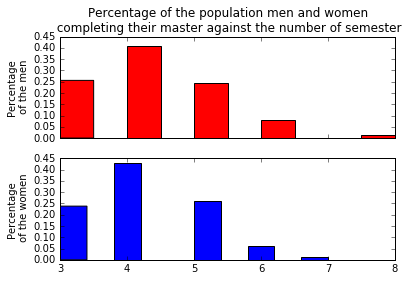

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

number_men = len(men_master_student.index)
number_women = len(women_master_student.index)

f, axarr = plt.subplots(2, sharex=True)
axarr[0].hist(women_master_student['Time to Finish'].values, alpha=1, bins=10,color='red',stacked=True,
        weights=np.zeros_like(women_master_student['Time to Finish']) + 1. / number_women)
axarr[1].hist(men_master_student['Time to Finish'].values,alpha=1, bins=10, stacked=True,
         weights=np.zeros_like(men_master_student['Time to Finish']) + 1. / number_men)
axarr[0].set_title('Percentage of the population men and women\n completing their master against the number of semester')
axarr[0].set_ylabel('Percentage\n of the men')
axarr[1].set_ylabel('Percentage\n of the women')

We see that the distributions look really the same, the slight shift and the different thicknesses being an artifcat from the visualisation. This visualisation helps us then to understand that the difference in the distributions is really NOT significative.

The last task that we perform is a scatterplot to see the evolution over time of the duration of the master.

In [14]:
def scatterCount(frame) :
    """
        As scatter needs 3 vectors, we vectorize the data from our frame.
        @param frame  : the DataFrame with the duration of the studies of each student and the year they started
        @return x[rows.ravel()] : vectorized version of the duration of the master, with each entry repeated for plotting
        @return y[rows.ravel()] : vectorized version of the starting year of the master, with each entry repeated for plotting
        @return s :               the sum of all students that finished in a given time during a given year    
    """
    x = np.array([3,4,5,6,7,8])
    y = np.array([2007,2008,2009,2010,2011,2012,2013,2014,2015])
    rows, cols = np.indices((x.shape[0], y.shape[0]))
    s = np.zeros(len(x[rows.ravel()]))
    for sciper in frame.index :
        #Position in the vector s
        index =((frame.loc[sciper,['Time to Finish']].values[0]-3)*y.shape[0]
                +frame.loc[sciper,['Starting Year']].values[0]-2007)
        s[index]+=3000/len(frame.index) 
    return x[rows.ravel()],y[cols.ravel()],s

/home/thomas/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


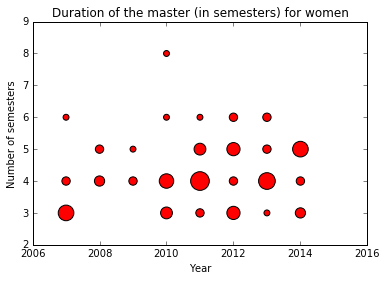

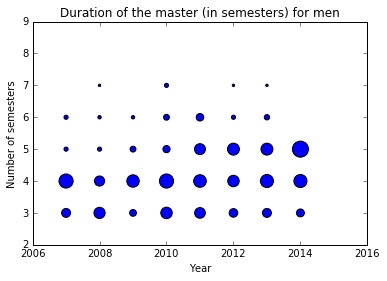

In [15]:
x_men,y_men,s_men=scatterCount(men_master_student)
x_women,y_women,s_women=scatterCount(women_master_student)

plt.figure(1)
plt.scatter(y_women,x_women, s_women,'r')
plt.title('Duration of the master (in semesters) for women')
plt.ylabel('Number of semesters')
plt.xlabel('Year')
plt.figure(2)
plt.scatter(y_men,x_men, s_men,alpha=1)
plt.title('Duration of the master (in semesters) for men')
plt.ylabel('Number of semesters')
plt.xlabel('Year')